In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [88]:
function envelope(t)
    if t < 2
        return sin(pi/4*t)^2
    elseif 28 < t <= 30
        return cos(pi/4*(t-28))^2
    else
        return 1
    end
end

h_times = LinRange(0,30,72+2)[2:end-1]
dt = h_times[1]
function pulse(p, t)
    out = 0
    w_sum = 0
    for (i, ht) in enumerate(h_times)
        w = exp( - 5/(2*dt^2) * (t - ht)^2)
        out += p[i] * w
        w_sum += w
    end
    envelope(t)*out/w_sum
    # out/w_sum
end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

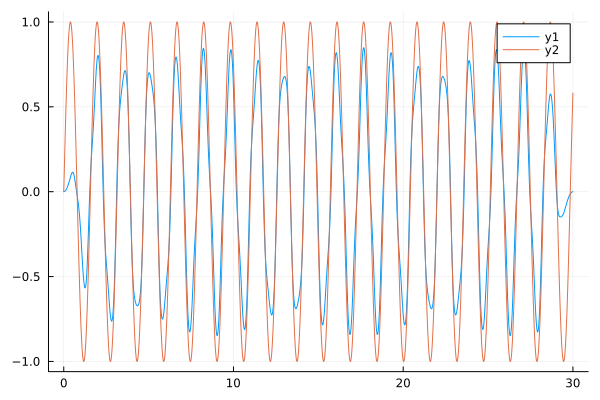

In [93]:
times = LinRange(0,30,5000)
rand_ps = sin.(4*h_times)
# rand_ps = rand(72).-0.5

plot(times,[pulse(rand_ps,t) for t in times])
plot!(times,sin.(4*times))

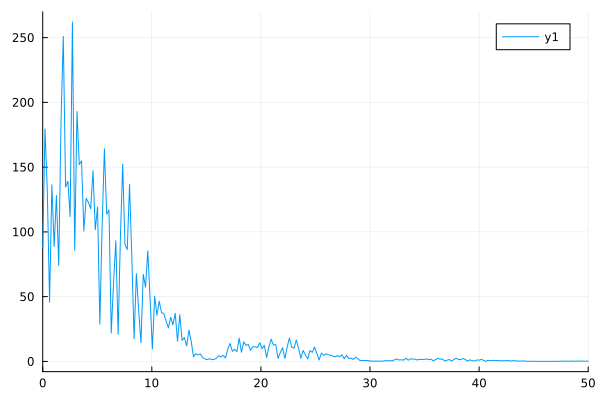

In [85]:
using FFTW
Ts = times[2]
F = fft([pulse(rand_ps,t) for t in times]) |> fftshift
# F = fft([sin(t) for t in times]) |> fftshift
freqs = fftfreq(length(times), 1/Ts) |> fftshift

plot(freqs*2*pi,abs.(F),xlim=(-0.001,50))

In [155]:
p = 0.01 .*(rand(72).-0.5) ;#zeros(72) ; 

In [156]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

M = Pot3Const * exp(im * phi_ext) * Pot3Mat

ψ0 = ψs'*ψs[:,1:2]

# Hphimærke = dPot3_dphi(phi_ext)
# Hphi = KinPot12 + Potential3
# IdNH = diagm(ones(ComplexF64, NHilbert))
# E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
# E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
# tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
# tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))

fu0 = cat(ψ0,zeros(NHilbert,1),zeros(NHilbert,1),dims=2)#cat(ψ0,-tmp1*ψs[:,1],-tmp2*ψs[:,2],dims=2)
fu0 = cat(fu0,zeros(1,4),dims=1)
sizep = length(p)

D = spdiagm(Es.- Es[1]) ;
V = ψs'*chargecoupling*ψs ;

In [157]:
function f!(du, u, p, t)
    x = u[1:end-1,1:2]
    ψ = u[1:end-1,3:4]
    α = 1#alpha(p,t)
    H = D + pulse(p,t) .* V

    du[1:end-1,1:2] = -im .* (H * x)
    du[1:end-1,3:4] .= 0.0#-im .* (H * ψ) - α .* ((M - M') * x)

    proj = abs2.(ψ0'*x)

    du[end,1] = sum(proj)
end

Uv = chargecoupling
Ua = Potential3#Um + Um'
dUa = M - M'

l1sscale = 0

lfactor = 0.5/30# * l1sscale
function b!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    λ = u[:,5:6]
    ϕ = u[:,7:8]
    α = 1#alpha(p,t)
    # dαdp = dalphadp(p,t)
    dpdp = dpulsedp(p,t)
    
    tψ0 = ψ0[:,1]
    tψ1 = ψ0[:,2]

    miH = -im .* (D + pulse(p,t) .* V)

    du[:,1:2] = miH * x
    du[:,3:4] .= 0.0#miH * ψ - α * dUa * x
    du[:,5:6] = miH * λ - lfactor .* cat(tψ0 * (tψ0'*x[:,1]) + tψ1 * (tψ1'*x[:,1]), 
                                         tψ0 * (tψ0'*x[:,2]) + tψ1 * (tψ1'*x[:,2]),dims=2)
    du[:,7:8] .= 0.0#miH * ϕ + α * dUa * λ + lfactor .* cat(tψ0 * (tψ0'*ψ[:,1]) + tψ1 * (tψ1'*ψ[:,1]), 
                                                       #tψ0 * (tψ0'*ψ[:,2]) + tψ1 * (tψ1'*ψ[:,2]),dims=2)
    
    du[1:sizep,9] = 2 .* (
    - real(im * tr(λ' * V * x)) .* dpdp )
    # - real(im * tr(λ' * Ua * x)) .* dαdp )
    
    du[8,9] = 0.0#2 * real(tr(λ' * dUa * x) * α)
    
    # du[sizep+1:2*sizep,9] = 2 .* (
    # - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpdp 
    # - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dαdp 
    # # + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) 
    # - real(tr(x' * dUa * λ)) .* dαdp )
    # # - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)

    du[sizep+1:2*sizep,9] .= 0.0
end

b! (generic function with 1 method)

In [158]:
m = l1sscale#0.001/pi#0.001/pi #pi*2e-6
ls = []
l1s = []
l2s = []
params = []
counter = [0]

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        counter[1] += 1
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # DT = sol_f.u[end][:,1]
        # UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
        # UvT = sol_f.u[end][:,N+2:2*N+1]
        xT = sol_f.u[end][1:end-1,1:2]
        ψT = sol_f.u[end][1:end-1,3:4]

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        int_inf = 1 - lfactor * real(sol_f.u[end][end,1])

        λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
        #Multiplying by 0 instead of 0.5
        ϕ = 0.0 .* cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # UT = abs2.(ψ0'*xT)
        # infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        grad_phi = real(sol_b.u[end][8,9])

        loss[1] = infidelity + int_inf + m * abs(grad_phi)
        grad[:] = real(sol_b.u[end][1:sizep,9]) + m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,9])
        grad[8] = 0
        push!(ls, copy(infidelity))
        push!(l1s, copy(int_inf))
        push!(l2s, copy(grad_phi))
        push!(params, copy(p))

        if counter[1]%5 == 0
            image = plot([ls,ls + l1s + m .* abs.(l2s)],yscale=:log10,ylim=(1e-5,2))
            savefig(image,"tmp_loss.png")

            writedlm("tmp_ls.txt",ls)
            writedlm("tmp_l1.txt",l1s)
            # writedlm("tmp_l2.txt",l2s)
            writedlm("tmp_paramsmm.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    # println(ls[end]," ",l1s[end]," ",l2s[end]," ",loss[1])
end

get_grad! (generic function with 1 method)

In [159]:
initial_p = copy(p)
last_p = similar(initial_p);

In [160]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()))

In [152]:
ls

1-element Vector{Any}:
 1.0